# HEALTH INSURANCE CROSS SELL PREDICTION

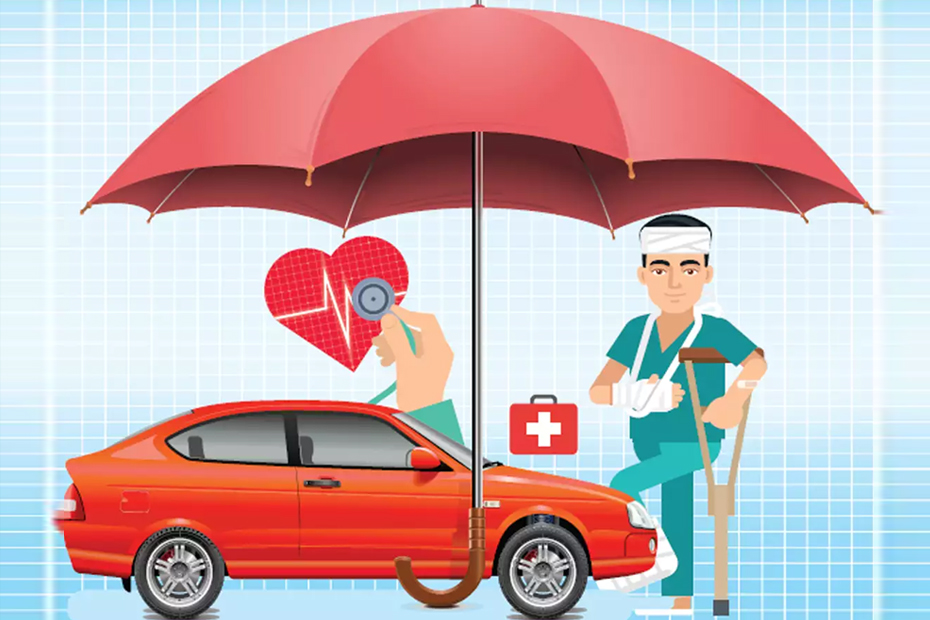

Our client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from the past year will also be interested in Vehicle Insurance provided by the company.

An insurance policy is an arrangement by which a company undertakes to provide a guarantee of compensation for specified loss, damage, illness, or death in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarantee.

For example, you may pay a premium of Rs. 5000 each year for a health insurance cover of Rs. 200,000/- so that if God forbid, you fall ill and need to be hospitalized in that year, the insurance provider company will bear the cost of hospitalization, etc. for up to Rs. 200,000. Now if you are wondering how can the company bear such high hospitalization costs when it charges a premium of only Rs. 5000/-, that is where the concept of probabilities comes into the picture. For example, like you, there may be 100 customers who would be paying a premium of Rs. 5000 every year, but only a few of them (say 2-3) would get hospitalized that year, and not everyone. This way everyone shares the risk of everyone else.

Just like medical insurance, there is vehicle insurance where every year customer needs to pay a premium of a certain amount to insurance provider company so that in case of unfortunate accident by the vehicle, the insurance provider company will provide compensation (called ‘sum assured’) to the customer.

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimize its business model and revenue.

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel), etc.

## Data Description
**id:** Unique ID for the customer

**Gender:** Gender of the customer

**Age:** Age of the customer

**Driving_License	0 :** Customer does not have DL, **1 :** Customer already has DL

**Region_Code:** Unique code for the region of the customer

**Previously_Insured	1 :** Customer already has Vehicle Insurance, **0 :** Customer doesn't have Vehicle Insurance

**Vehicle_Age:** Age of the Vehicle

**Vehicle_Damage	1 :** Customer got his/her vehicle damaged in the past. **0 :** Customer didn't get his/her vehicle damaged in the past.

**Annual_Premium:**	The amount customer needs to pay as premium in the year

**PolicySalesChannel:**	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.

**Vintage:**	Number of Days, Customer has been associated with the company

**Response	1 :** Customer is interested, **0 :** Customer is not interested

### Import Libraries

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Import Dataset

In [ ]:
train=pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction/train.csv')
test=pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction/test.csv')
sub = pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction/sample_submission.csv')

In [ ]:
train.head()

In [ ]:
train.shape

In [ ]:
train.isnull().sum()

***There is no missing data.***

In [ ]:
train.drop("id",axis =1).quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T

### Check Columns (Categorical or Numeric)

In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    It gives the names of categorical, numerical, and categorical but cardinal variables in the data set.
    Note: Categorical variables with numerical appearance are also included in categorical variables.

    Parameters
    ------
        dataframe: dataframe
        cat_th: int, optional
                the class threshold for numeric but categorical variables
        car_th: int, optinal
                the class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical Variables List
        num_cols: list
                Numeric Variables List
        cat_but_car: list
                Categorical but cardinal variables list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is in cat_cols

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(train)

In [ ]:
cat_cols

In [ ]:
num_cols = [col for col in num_cols if "id" not in col]
num_cols = [col for col in num_cols if "Policy_Sales_Channel" not in col]

In [ ]:
# SUMMARY CATEGORICAL COLUMNS
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


for i in cat_cols:
    cat_summary(train, i, plot=True)

In [ ]:
# SUMMARY NUMERIC COLUMNS
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    print("#####################################")

for col in num_cols:
    num_summary(train, col, plot=True)

In [ ]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [ ]:
for col in num_cols:
    target_summary_with_num(train, "Response", col)

In [ ]:
sns.boxplot(x=train["Age"])

In [ ]:
sns.boxplot(x=train["Annual_Premium"])

In [ ]:
sns.boxplot(x=train["Vintage"])

### Gender-Response Visualization

In [ ]:
sns.countplot(train.Gender)

In [ ]:
df=train.groupby(['Gender','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()

In [ ]:
g = sns.catplot(x="Gender", y="count",col="Response",
                data=df, kind="bar",
                height=4, aspect=.7);

### Driving license-Gender Visualization

In [ ]:
df=train.groupby(['Gender'])['Driving_License'].count().to_frame().reset_index()
df

In [ ]:
sns.catplot(x="Gender", y="Driving_License",
                data=df, kind="bar");

### Response-Vehicle age Visualization

In [ ]:
df=train.groupby(['Vehicle_Age','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()
df

In [ ]:
g = sns.catplot(x="Vehicle_Age", y="count",col="Response",
                data=df, kind="bar",
                height=4, aspect=.7);

### Damage Vehicle-Response Visualization

In [ ]:
df=train.groupby(['Vehicle_Damage','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()

In [ ]:
g = sns.catplot(x="Vehicle_Damage", y="count",col="Response",
                data=df, kind="bar",
                height=4, aspect=.7);

# DATA PREPROCESSING

## OUTLIERS

In [ ]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 3 * interquantile_range
    low_limit = quartile1 - 3 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [ ]:
for col in num_cols:
    print(f"{col} : {check_outlier(train,col)}")

In [ ]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

In [ ]:
for col in num_cols:
    col, grab_outliers(train, col)

In [ ]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [ ]:
for col in num_cols:
    replace_with_thresholds(train, col)

In [ ]:
# CHECK OUTLIERS AGAIN
for col in num_cols:
    print(f"{col} : {check_outlier(train,col)}")

In [ ]:
train.drop("id",axis =1).quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T

## CORRELATION ANALYSIS

In [ ]:
df.corrwith(train["Response"]).sort_values(ascending=False)
corr_df = train.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(corr_df, annot=True, xticklabels=corr_df.columns, yticklabels=corr_df.columns)

corr_df = corr_df.corr().unstack().sort_values().drop_duplicates()
corr_df = pd.DataFrame(corr_df, columns=["corr"])
corr_df.index.names = ['1', '2']
corr_df = corr_df.reset_index()
corr_df.sort_values(by="corr", ascending=True).head(30)

high_corr = corr_df[(corr_df["corr"] >= 0.70) | (corr_df["corr"] <= -0.70)]
high_corr

## FEATURE ENGINEERING

In [ ]:
train['Gender'] = train['Gender'].map( {'Female': 0, 'Male': 1} ).astype(int)

In [ ]:
train=pd.get_dummies(train,drop_first=True)

In [ ]:
train

In [ ]:
train=train.rename(columns={"Vehicle_Age_< 1 Year": "Vehicle_Age_lt_1_Year", "Vehicle_Age_> 2 Years": "Vehicle_Age_gt_2_Years"})
train['Vehicle_Age_lt_1_Year']=train['Vehicle_Age_lt_1_Year'].astype('int')
train['Vehicle_Age_gt_2_Years']=train['Vehicle_Age_gt_2_Years'].astype('int')
train['Vehicle_Damage_Yes']=train['Vehicle_Damage_Yes'].astype('int')

In [ ]:
train["premium_age_ratio"] = train["Annual_Premium"]/train["Age"]

In [ ]:
train["premium_vintage_ratio"] = train["Annual_Premium"]/train["Vintage"]

In [ ]:
train

In [ ]:
num_feat = ['Age','Vintage','premium_age_ratio','premium_vintage_ratio']
ss = StandardScaler()
train[num_feat] = ss.fit_transform(train[num_feat])

In [ ]:
mm = MinMaxScaler()
train[['Annual_Premium']] = mm.fit_transform(train[['Annual_Premium']])

In [ ]:
train=train.drop('id',axis=1)

In [ ]:
cat_feat = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age_lt_1_Year','Vehicle_Age_gt_2_Years','Vehicle_Damage_Yes']
for column in cat_feat:
    train[column] = train[column].astype('str')

### Applying the same processes to the Test Data

In [ ]:
test['Gender'] = test['Gender'].map( {'Female': 0, 'Male': 1} ).astype(int)
test=pd.get_dummies(test,drop_first=True)
test=test.rename(columns={"Vehicle_Age_< 1 Year": "Vehicle_Age_lt_1_Year", "Vehicle_Age_> 2 Years": "Vehicle_Age_gt_2_Years"})
test['Vehicle_Age_lt_1_Year']=test['Vehicle_Age_lt_1_Year'].astype('int')
test['Vehicle_Age_gt_2_Years']=test['Vehicle_Age_gt_2_Years'].astype('int')
test['Vehicle_Damage_Yes']=test['Vehicle_Damage_Yes'].astype('int')
test["premium_age_ratio"] = test["Annual_Premium"]/test["Age"]
test["premium_vintage_ratio"] = test["Annual_Premium"]/test["Vintage"]
test=test.drop('id',axis=1)

In [ ]:
ss = StandardScaler()
test[num_feat] = ss.fit_transform(test[num_feat])


mm = MinMaxScaler()
test[['Annual_Premium']] = mm.fit_transform(test[['Annual_Premium']])

In [ ]:
for column in cat_feat:
    test[column] = test[column].astype('str')

### Train-Test Split

In [ ]:
training_data, testing_data = train.drop('Response', axis=1),train['Response']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(training_data,testing_data, test_size=0.2, random_state=42)

In [ ]:
x_train

In [ ]:
x_test

In [ ]:
for column in cat_feat:
    x_train[column] = x_train[column].astype('int')
    x_test[column] = x_test[column].astype('int')

In [ ]:
for column in num_feat:
    x_train[column] = x_train[column].astype('int')
    x_test[column] = x_test[column].astype('int')

## XGBOOST

In [ ]:
model_xgb = XGBClassifier()
model_xgb.fit(x_train, y_train,eval_metric='mlogloss')

pred_xgb = model_xgb.predict(x_test) 
predictions_xgb = [round(value) for value in pred_xgb]
accuracy_xgb = accuracy_score(y_test, predictions_xgb)
print("Accuracy: %.2f%%" % (accuracy_xgb * 100.0))

In [ ]:
#params = {
    #"max_depth" : range(2,10,1),
    #"n_estimators" : range(60,220,40),
    #"learning_rate" : [0.1,0.01,0.05]}

In [ ]:
#grid_search_xgb = GridSearchCV(model_xgb,
                               #param_grid = params,
                               #scoring = 'roc_auc',
                               #n_jobs = 10,
                               #cv = 10,
                               #verbose = True)

In [ ]:
#grid_search_xgb.fit(x_train,y_train)

In [ ]:
#grid_search_xgb.best_estimator_

In [ ]:
model_xgb_tuned = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                                colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
                                gamma=0, gpu_id=-1, importance_type=None,
                                interaction_constraints='', learning_rate=0.1, max_delta_step=0,
                                max_depth=5, min_child_weight=1,eval_metric='mlogloss',
                                monotone_constraints='()', n_estimators=180, n_jobs=12,
                                num_parallel_tree=1, predictor='auto', random_state=0,
                                reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
                                tree_method='exact', validate_parameters=1, verbosity=None)


model_xgb_tuned.fit(x_train, y_train)
pred_xgb_tuned = model_xgb_tuned.predict(x_test) 
predictions_xgb_tuned = [round(value) for value in pred_xgb_tuned]
accuracy_xgb_tuned = accuracy_score(y_test, predictions_xgb_tuned)
print("Accuracy: %.2f%%" % (accuracy_xgb_tuned * 100.0))

***Let use all values in the train set to estimate Response values in test data. Then we'll compare prediction Responses according to the Submission data. Because the sample_submission.csv has actual Responses values. We can see how our model is good.***

In [ ]:
X_train, Y_train = train.drop("Response",axis = 1), train["Response"]

In [ ]:
X_train

In [ ]:
Y_train

In [ ]:
test

In [ ]:
for column in cat_feat:
    X_train[column] = X_train[column].astype('int')
    test[column] = test[column].astype('int')

In [ ]:
for column in num_feat:
    X_train[column] = X_train[column].astype('int')
    test[column] = test[column].astype('int')

In [ ]:
from xgboost import XGBClassifier, plot_importance

# fit model no training data
model2 = XGBClassifier(eval_metric='mlogloss')
model2.fit(X_train, Y_train)

y_pred1 = model2.predict(test)
predictions2 = [round(value) for value in y_pred1]

In [ ]:
test_2 = pd.DataFrame()

In [ ]:
test_2['Response'] = sub['Response']
test_2["Pred_Response"] = predictions2

In [ ]:
test_2

In [ ]:
accuracy_2 = accuracy_score(test_2['Response'].values, test_2['Pred_Response'].values)
print("Accuracy: %.2f%%" % (accuracy_2 * 100.0))